# Least Absolute Shrinkage and Selection Operator

Learning a model through the OLS loss can be done very efficiently through either gradient descent or even through the Normal equations. The same is true for ridge regression. For the Lasso formulation however, the non differentiability of the absolute value at $0$ makes the learning more tricky.

One approach, known as ISTA (see Amir Beck and Marc Teboulle, A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems) consists in combining traditional gradient descent steps with a projection onto the $\ell_1$ norm ball. Concretely, for the LASSO objective

$$\begin{align}
\ell(\boldsymbol \beta) = \|\boldsymbol X\boldsymbol \beta - \boldsymbol t\|^2_2 + \lambda \|\boldsymbol \beta\|_1
\end{align}$$

where $\boldsymbol \beta = (\beta_1, \beta_2,\ldots, \beta_D)$ (note that we don't include the bias) and the feature vectors $\left\{\boldsymbol  x_i\right\}_{i=1}^N$ (corresponding to the rows of the matrix $\boldsymbol X$) as well as the targets $t_i$ are assumed to be centered, i.e.$$\begin{align}
\boldsymbol x_{ij} \leftarrow \boldsymbol x_{ij}-  \frac{1}{N}\sum_{i=1}^{N} x_{ij}\\
t_i \leftarrow t_i - \frac{1}{N}\sum_{i=1}^N t_i
\end{align}$$

(Note that this is equivalent to taking $\beta_0 = \frac{1}{N}\sum_{i=1}^N t_i$). The ISTA update takes the form

$$\begin{align}
\boldsymbol \beta^{k+1} \leftarrow \mathcal{T}_{\lambda \eta} (\boldsymbol \beta^{k} - 2\eta \mathbf{X}^T(\mathbf{X}\mathbf{\beta^{k}} - \mathbf{t}))
\end{align}$$

where $\mathcal{T}_{\lambda \eta}(\mathbf{x})_i$ is the thresholding operator defined component-wise as

$$\begin{align}
\mathcal{T}_{\lambda \eta}(\boldsymbol x)_i = (|\boldsymbol x_i| - \lambda \eta)_+ \text{sign}(\boldsymbol x_i)
\end{align}$$

In the equations above, $\eta$ is an appropriate step size and $(x)_+ = \max(x, 0)$

### ISTA
The following function 'ISTA' returns a final estimate for the regression vector $\mathbf{\beta}$ given a feature matrix $\mathbf{X}$, a target vector $\mathbf{t}$ (the function includes the centering steps for $\mathbf{x}_i$ and $t_i$) regularization weight $\lambda$, and the choice for the learning rate $\eta$.

In [14]:
def ISTA(beta_init, X, t, lbda, eta):
    '''The function takes as input an initial guess for beta, a set of feature vectors stored in X and their corresponding 
    targets stored in t, a regularization weight lbda, step size parameter eta and must return the regression weights following from the minimization of 
    the LASSO objective'''
    
    # initialize variables
    N = np.shape(X)[0] # size of dataset
    beta_LASSO = beta_init.reshape(-1,1)
    MaxIter = 1000
    loss_ista = np.zeros(MaxIter)

    # centralize features X and target values t
    X = X - np.ones((N,N))@X/N
    t = t - np.ones((N,N))@t/N
    t = t.reshape(-1,1)
    
    # run the update for beta_LASSO
    for i in range(MaxIter):
        arg = beta_LASSO - 2*eta* X.transpose() @ (X @ beta_LASSO - t)
        beta_LASSO = np.multiply( np.maximum(np.absolute(arg)-lbda*eta , 0) , np.sign(arg))
        loss_ista[i] = np.sum((X @ beta_LASSO - t) ** 2) + lbda*np.sum(beta_LASSO) # record the loss
        
    return beta_LASSO, loss_ista

Now we apply to the data from a linear model with Gaussian noise (in red) the algorithm which uses polynomial features up to degree 9. The prediction results are displayed on top of the true model (in blue).

d=2, beta = [0.74480172 0.60309765]
d=3, beta = [0.57622487 0.44667135 0.31518188]
d=4, beta = [ 0.61316134  0.48878385  0.26809363 -0.04741692]
d=5, beta = [ 0.7453979   0.38760406  0.2161204  -0.04611035  0.01865803]
d=6, beta = [ 0.68255718  0.38715966  0.29662896  0.14412914 -0.1544024  -0.06180628]
d=7, beta = [ 0.70057418  0.45843934  0.21210507  0.05532449  0.04386789 -0.09825964
 -0.09231602]
d=8, beta = [ 0.68387418  0.52486929  0.11559724  0.10295417  0.09697928  0.01205555
 -0.21004173 -0.06706743]
d=9, beta = [ 0.74868327  0.44773429  0.19545041  0.04851404  0.00300115 -0.06010142
 -0.08212479  0.03797716 -0.06531204]


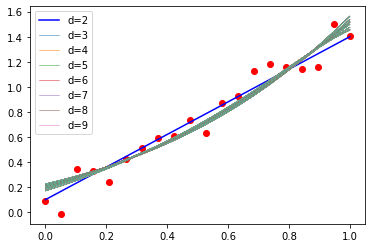

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# set up the true model
x = np.linspace(0,1,20)
x_true = np.linspace(0,1,100)
t_true = 0.1 + 1.3*x_true
# set up our data points, given by the true model with gaussian perturbation
t_noisy = 0.1 + 1.3*x + np.random.normal(0,0.1,len(x))
plt.scatter(x, t_noisy, c='r')
plt.plot(x_true, t_true, c='b')

# set up parameters for ISTA
eta = 1e-3
lbda = 0.05
# try polynomials with different degree d 
degree = [2,3,4,5,6,7,8,9]

for d in degree:
    beta = np.random.normal(0,0.1,size=d).reshape(-1,1) # randomly initialize beta
    poly = PolynomialFeatures(d) # initialize the polynomail model
    X_poly = poly.fit_transform(x.reshape((-1,1)))[:,1:] # tranform x into polynomial features and discard the "dummy" feature x^0=1
    # run the LASSO update w.r.t. beta for MaxIter number of times
    beta, _ = ISTA(beta, X_poly, t_noisy, lbda, eta)
    # to make predictions and display the result, we need to first centralize the input data
    N = np.shape(X_poly)[0] # number of data points
    X_polyMean = np.ones((N,N))@X_poly/N # this is what we subtracted from the features for centralization
    t_noisyMean = np.ones((N,N))@t_noisy/N # this is what we subtracted from the targets for centralization
    plt.plot(x , (X_poly-X_polyMean) @ beta + t_noisyMean, linewidth=0.5 )
    print('d=%d, beta ='%d, beta.flatten())
    
plt.legend(["d=%d"%d for d in degree])
plt.show()

### FISTA
It is possible to improve the ISTA updates by combining them with Nesterov accelerated gradient descent. The resulting update, known as FISTA can read, for a constant step size, by letting $\mathbf{y}^{(1)} = {\boldsymbol \beta}^{(0)}$, $\eta^{(1)} = 1$ and then using

$$\begin{align}
\left\{
\begin{array}{l}
&\boldsymbol{\beta}^{(k)} = \text{ISTA}(\mathbf{y}^{(k)}) \text{  (with $y^k$ playing the role of $\beta^{k-1}$ as in ISTA, and a suitable constant learning rate)}\\
&\eta^{(k+1)} = \frac{1+\sqrt{1+4(\eta^{(k)})^2}}{2}\\
&\mathbf{y}^{(k+1)} = \mathbf{\boldsymbol\beta}^{(k)} + \left(\frac{\eta^{(k)} - 1}{\eta^{(k+1)}}\right)\left({\boldsymbol\beta}^{(k)} - {\boldsymbol\beta}^{(k-1)}\right)\end{array}\right.
\end{align}$$

Here $\text{ISTA}$ denotes a single ISTA update.

In [27]:
def FISTA(X, t, eta, beta0, lbda):
    
    '''function should return the solution to the minimization of the LASSO objective ||X*beta - t||_2^2 + lambda*||beta||_1
    by means of FISTA updates'''
  
    # set up variables for iterations
    MaxIter = 1000
    loss_fista = np.zeros(MaxIter)
    beta = beta0
    beta_prev = beta0
    eta_now = 1
    eta_prev = eta_now
    y = beta0 # y1=beta0
    N = np.shape(X)[0] # size of dataset
    loss_ista = np.zeros((MaxIter, 1))

    # normalize features X and target values t
    X = X - np.ones((N,N))@X/N
    t = t - np.ones((N,N))@t/N 
    t = t.reshape(-1,1)
    # fista iterations

    for k in range(1, MaxIter+1): # k starts from 1    
        # the first line, updating beta using a single ISTA update
        # y takes the place of beta while eta is held fixed as eta1
        # use the learning rate eta
        arg = y - 2*eta* X.transpose() @ (X @ y - t)
        beta = np.multiply( np.maximum(np.absolute(arg)-lbda*eta ,0) , np.sign(arg))
       
        # the second line, updating eta
        eta_now = (1 + np.sqrt(1+4*eta_now**2)) / 2
                
        # the third line, updating y
        y = beta + (eta_prev-1)/eta_now * (beta-beta_prev)
        # update for beta_prev and eta_prev
        beta_prev = beta
        eta_prev = eta_now
      
        # record the loss
        loss_fista[k-1] = np.sum((X @ beta - t) ** 2) + lbda*np.sum(beta)
    return beta , loss_fista # beta is the final beta_LASSO

Now apply the algorithm to the same true linear model as above.

d=2, beta = [0.96103102 0.26746676]
d=3, beta = [1.06035794 0.         0.18371104]
d=4, beta = [1.09276876 0.         0.         0.163435  ]
d=5, beta = [ 1.10795165  0.         -0.          0.          0.15903401]
d=6, beta = [ 1.11667984  0.         -0.         -0.          0.          0.16024837]
d=7, beta = [ 1.13846625  0.         -0.         -0.05222446 -0.          0.
  0.20593275]
d=8, beta = [ 1.16081203  0.         -0.         -0.09464505 -0.         -0.
  0.          0.24140049]
d=9, beta = [ 1.16714276  0.         -0.         -0.         -0.13471345 -0.
 -0.          0.          0.28642476]


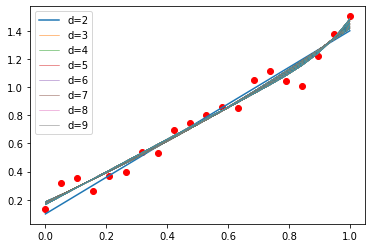

In [28]:
# set up the true model
x = np.linspace(0,1,20)
x_true = np.linspace(0,1,101)
t_true = 0.1 + 1.3*x_true
# set up our data points, given by the true model with gaussian perturbation
t_noisy = 0.1 + 1.3*x + np.random.normal(0,0.1,len(x))
plt.scatter(x, t_noisy, c='r')
plt.plot(x_true, t_true)

# set up the regularization parameter lambda
lbda = 0.01
# try polynomials with different degree d 
degree = [2,3,4,5,6,7,8,9]
for d in degree:
    beta0 = np.random.normal(0,0.1,size=d).reshape(-1,1) # randomly initialize beta
    poly = PolynomialFeatures(d) # initialize the polynomail model
    X_poly = poly.fit_transform(x.reshape((-1,1)))[:,1:] # tranform x into polynomial features and discard the "dummy" feature x^0=1
    # run the LASSO update using FISTA, eta = 0.05
    beta_LASSO, loss_fista = FISTA(X_poly, t_noisy, 0.05, beta0, lbda)
    # to make predictions and display the result, we need to first centralize the input data
    N = np.shape(X_poly)[0] # number of data points
    X_polyMean = np.ones((N,N))@X_poly/N # this is what we subtracted from the features for centralization
    t_noisyMean = np.ones((N,N))@t_noisy/N # this is what we subtracted from the targets for centralization
    plt.plot(x , (X_poly-X_polyMean) @ beta_LASSO + t_noisyMean, linewidth=0.5 )
    print('d=%d, beta ='%d, beta_LASSO.flatten())
    
plt.legend(["d=%d"%d for d in degree])
plt.show()

We compare the performance of ISTA and FISTA updates by plotting the evolution of their loss $\ell(\mathbf{\beta})$ as a function of the iterations for both approaches. Indeed we see that FISTA updates decreases the loss faster.

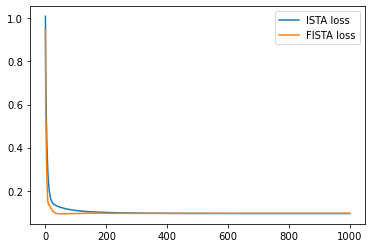

In [31]:
import matplotlib.pyplot as plt
MaxIter = 1000
ISTA_loss = np.zeros((MaxIter, 1))
FISTA_loss = np.zeros((MaxIter, 1))

# consider d=9
d=9
eta = 0.05
beta = np.random.normal(0,0.1,size=d).reshape(-1,1) # randomly initialize beta
poly = PolynomialFeatures(d) # initialize the polynomail model
X_poly = poly.fit_transform(x.reshape((-1,1)))[:,1:] # tranform x into polynomial features and discard the "dummy" feature x^0=1
_, ISTA_loss = ISTA(beta, X_poly, t_noisy, lbda, eta)
_, FISTA_loss = FISTA(X_poly, t_noisy, eta, beta0, lbda)
plt.plot(ISTA_loss, label='ISTA loss')
plt.plot(FISTA_loss, label='FISTA loss')
plt.legend()
plt.show()